In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cupy as cp
import os
import random
import xraylib
import sys
%matplotlib inline

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

# Init data sizes and parametes of the PXM of ID16A

In [15]:
# energy = float(sys.argv[1])  # [keV] xray energy
# z1p = float(sys.argv[2])# positions of the probe and code for reconstruction
# # z1p = 270e-3# positions of the probe and code for reconstruction
# ill_feature_size = float(sys.argv[3])
# use_prb = sys.argv[4]=='True'
# use_code = sys.argv[5]=='True'
# ndist = int(sys.argv[6])
###################
energy = 33.35  # [keV] xray energy
z1p = 8e-3# positions of the probe and code for reconstruction
# z1p = 270e-3# positions of the probe and code for reconstruction
ill_feature_size = 1e-6
use_prb = False
use_code = False
ndist = 4
###################

flg = f'{energy}_{z1p:.1e}_{ill_feature_size:.1e}_{use_prb}_{use_code}_{ndist}'
print(flg)

n = 256  # object size in each dimension
ntheta = 256  # number of angles (rotations)

pn = 256  # tomography chunk size for GPU processing
ptheta = 256  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size


wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28

sx0 = 3.7e-4
# z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
# z1[:] = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2


z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


33.35_8.0e-03_1.0e-06_False_False_4
[0.00420013 0.00402658 0.0034558  0.00266878] [-0.00199428 -0.00182073 -0.00124995 -0.00046292]
[0.00220585 0.00220585 0.00220585 0.00220585]


## Read real and imaginary parts of the refractive index u = delta+i beta

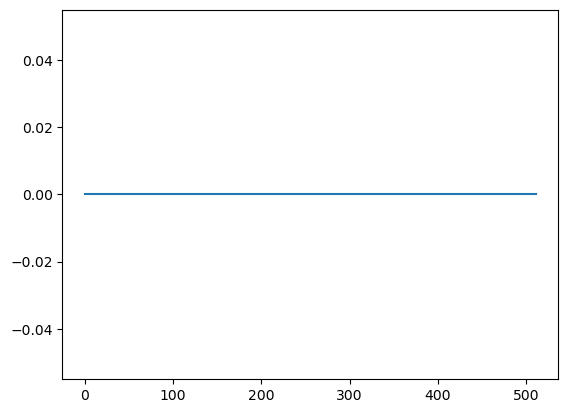

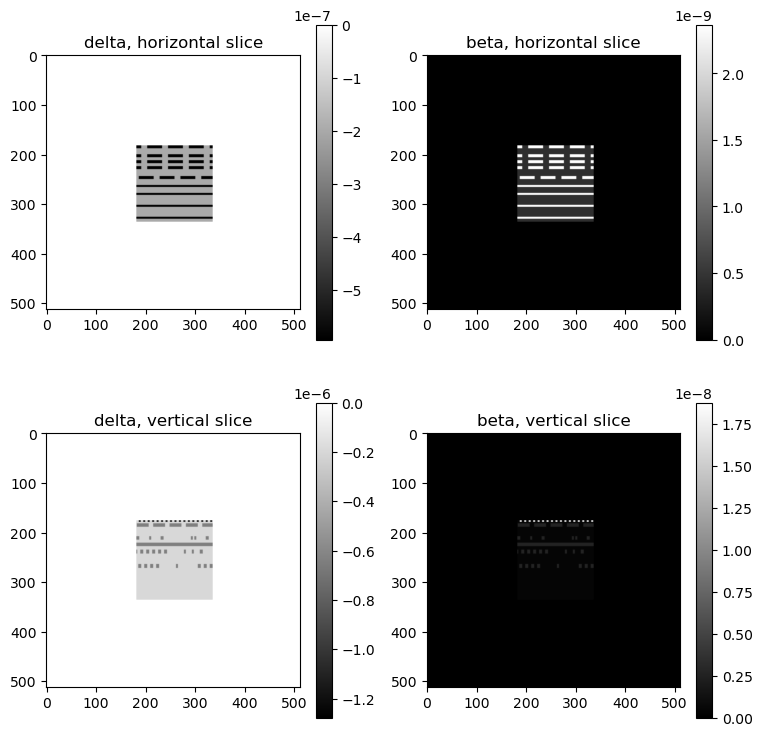

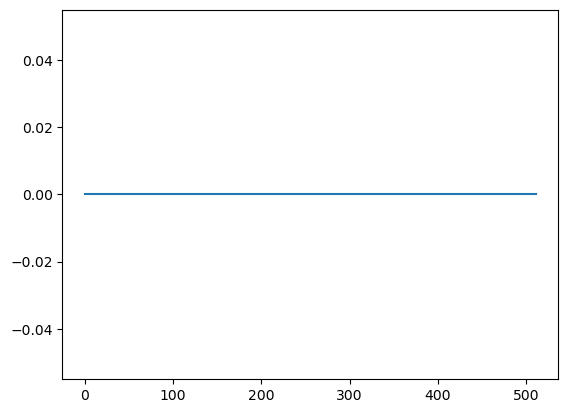

In [3]:
# Load a 3D object
beta0 = dxchange.read_tiff('data/beta-chip-192.tiff')
delta0 = dxchange.read_tiff('data/delta-chip-192.tiff')
delta0 = ndimage.zoom(delta0,n/256,order=1)
beta0 = ndimage.zoom(beta0,n/256,order=1)

pad = True
ne = n*2
# pad with zeros
beta = np.zeros([ne, ne, ne], dtype='float32')
delta = np.zeros([ne, ne, ne], dtype='float32')
delta[ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2,ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2,ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2] = delta0
beta[ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2,ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2,ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2] = beta0

u = delta+1j*beta
u = u.astype('complex64')/1.5 #to have max phase as 2
plt.figure()
plt.plot(u[:,n//2,n//2].real)

# v = np.arange(-n//2,n//2)/n
# [vx,vy,vz] = np.meshgrid(v,v,v)
# v=np.exp(-25*(vx**2+vy**2+vz**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u)))
# u = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v)))
# u = u.astype('complex64')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[ne//2].real,cmap='gray')
axs[0,0].set_title('delta, horizontal slice')
fig.colorbar(im)
im=axs[0,1].imshow(u[ne//2].imag,cmap='gray')
axs[0,1].set_title('beta, horizontal slice')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,ne//2].real,cmap='gray')
axs[1,0].set_title('delta, vertical slice')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,ne//2].imag,cmap='gray')
axs[1,1].set_title('beta, vertical slice')
fig.colorbar(im)
plt.figure()
plt.plot(u[:,n//2,n//2].real)


# Make structured illumination

0.52675
76
[0.00420013 0.00420013 0.00420013 0.00420013] [-0.00199428 -0.00199428 -0.00199428 -0.00199428]


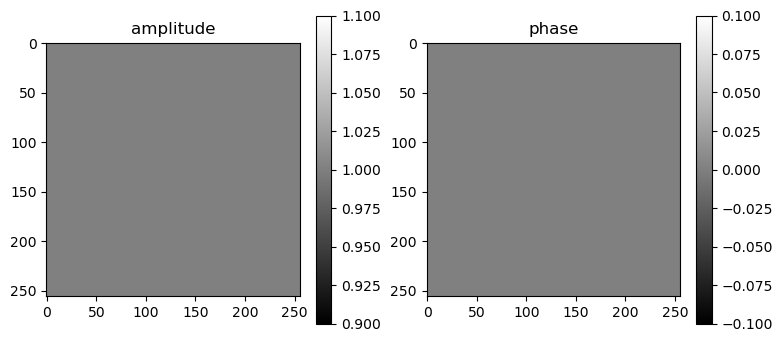

In [4]:
# make some large global code first
random.seed(10)
nill = 2**12
ill_global = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = np.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations

print(magnificationsp[0])
nill = int(ne*voxelsize/magnificationsp[0]//(ill_feature_size*2))*2
print(nill)
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
ill = ndimage.zoom(ill,[1,2*n/nill,2*n/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 3*1e-6/voxelsize # thickness in pixels

v = np.arange(-2*n//2,2*n//2)/2/n
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-10*(vx**2+vy**2))
fill = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(ill)))
ill = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fill*v)))
ill = ill.astype('complex64')


# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')

if use_code==False:
    psiill[:]=1
    
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)
print(distances,distancesp)



In [5]:
shifts_code = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/8

# Read a probe

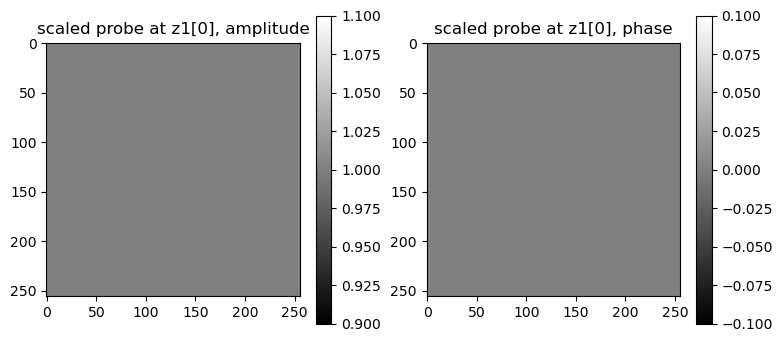

In [6]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0:ndist]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0:ndist]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
prb[:] = prb[0]
v = np.arange(-n//2,n//2)/n
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-20*(vx**2+vy**2))
fprb = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(prb)))
prb = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fprb*v)))
prb = prb.astype('complex64')

if use_prb==False:
    prb[:] = prb*0+1 # use just one!



fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)


## Create a solver class for tomography, use double sizes

In [7]:
tslv = holotomo.SolverTomo(theta, ntheta, ne, ne, pn*ne//n, center*ne//n)

note pn parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pn=n. If the gpu does not have enough memory then pn should  be decreased

## Create a solver class for holography

In [8]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

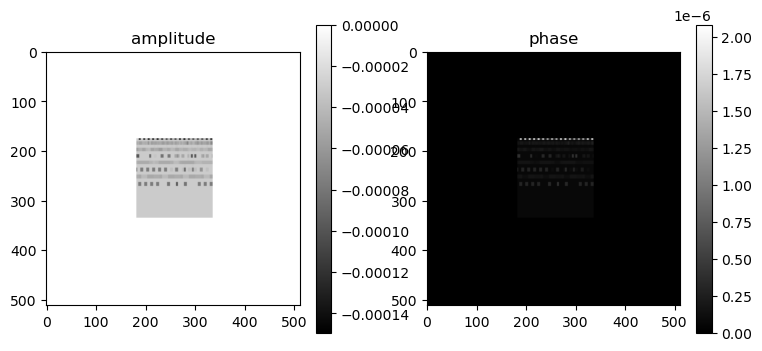

In [9]:
Ru = tslv.fwd_tomo_batch(u)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(Ru[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.imag(Ru[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

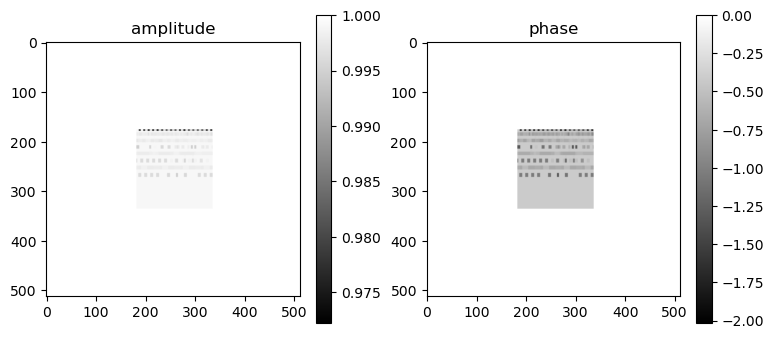

In [10]:
psi = pslv.exptomo(Ru)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

# Compute holographic projections for all angles and all distances

In [11]:
shifts = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16*0#*norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
fpsi = pslv.fwd_holo_batch(psi,prb,shifts_ref,psiill,shifts_code)
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1,shifts_ref,psiill,shifts_code) # ignore probe

pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad) 
fref = pslv0.fwd_holo_batch(psi[:1]*0+1,prb,shifts_ref[:,:1]*0,psiill,shifts_code[:,:1]*0) # ignore sample

nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]
nag [1. 1. 1. 1.]


## Take squared absolute value to simulate data on the detector, ref fields,

In [12]:
data = np.abs(fpsi)**2
data_ref = np.abs(fref)**2

## Show data and flat fields for different codes

<Figure size 640x480 with 0 Axes>

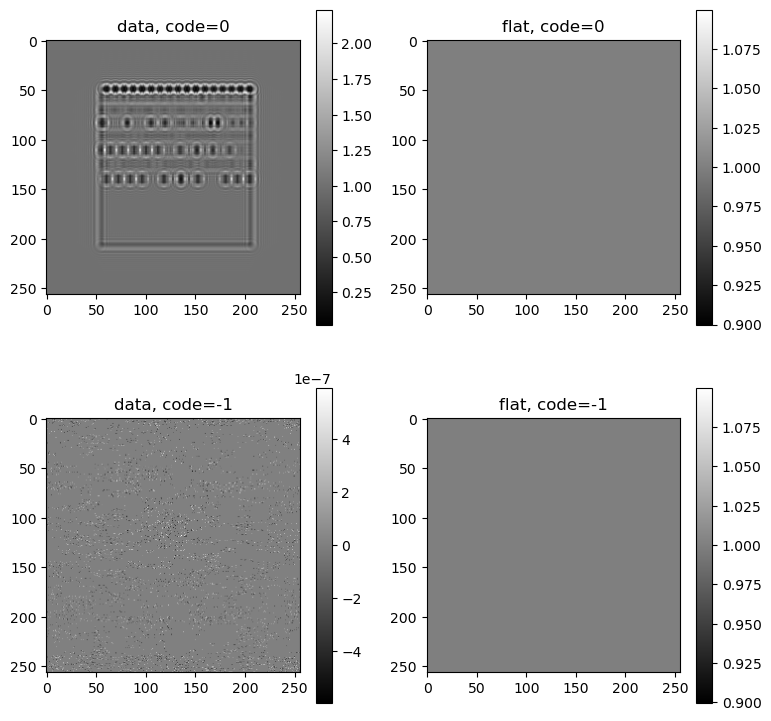

<Figure size 640x480 with 0 Axes>

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data, code=0')
fig.colorbar(im)
im=axs[0,1].imshow(data_ref[0,0],cmap='gray')
axs[0,1].set_title('flat, code=0')
fig.colorbar(im)
im=axs[1,0].imshow(data[-1,0]-data[0,0],cmap='gray')
axs[1,0].set_title('data, code=-1')
fig.colorbar(im)
im=axs[1,1].imshow(data_ref[-1,0],cmap='gray')
axs[1,1].set_title('flat, code=-1')
fig.colorbar(im)
plt.figure()


In [14]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'/data/vnikitin/modeling/data_chip_codes_{flg}_{k}',overwrite=True)
    dxchange.write_tiff(data_ref[0,0],f'/data/vnikitin/modeling/ref_chip_codes_{flg}_{k}',overwrite=True)
dxchange.write_tiff(psi[0,0],f'/data/vnikitin/modeling/psi_chip_{flg}',overwrite=True)


dxchange.write_tiff(np.abs(psiill),f'/data/vnikitin/modeling/psiill_abs_{flg}',overwrite=True)
dxchange.write_tiff(np.angle(psiill),f'/data/vnikitin/modeling/psiill_angle_{flg}',overwrite=True)

np.save(f'/data/vnikitin/modeling/shifts_{flg}',shifts)
np.save(f'/data/vnikitin/modeling/shifts_code_{flg}',shifts_code)
print(shifts_code.shape)

(4, 256, 2)
